In [3]:
from transformers import pipeline
from datasets import load_dataset
import requests
from PIL import Image
import os
import torch
from tqdm import tqdm

In [2]:
model_id = "llava-hf/llava-1.5-7b-hf"
pipe = pipeline("image-to-text", model=model_id, device_map="auto")

/home/govind/.conda/envs/modality_translation/lib/python3.10/site-packages/transformers/models/llava/configuration_llava.py:104: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.81s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
image1 = Image.open(requests.get("https://llava-vl.github.io/static/images/view.jpg", stream=True).raw)
image2 = Image.open(requests.get("http://images.cocodataset.org/val2017/000000039769.jpg", stream=True).raw)

In [4]:
image3 = Image.open("/scratch/govind/modality_translation/images_rgb_train/data/video-2BARff2EP7ZWkiF7n-frame-000432-pEpYGJT3PDodWjHHN.jpg")

In [5]:
prompt = "USER: <image>\nList the most relevant items in the scene.\nASSISTANT:"

outputs = pipe(image3, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

print(outputs[0]["generated_text"])

USER:  
List the most relevant items in the scene.
ASSISTANT: The most relevant items in the scene include a yellow crosswalk, a traffic light, cars parked on the side of the road, and people walking on the sidewalk. The traffic light is located near the center of the scene, and the cars are parked along the street, with some closer to the foreground and others further back. The people are walking on the sidewalk, with some closer to the traffic light and others further away. The scene captures a typical urban environment with pedestrians and vehicles sharing the space.


In [4]:
DATA_DIR = "/scratch/govind/modality_translation/images_thermal_train/data"
files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]

In [7]:
d = {}

In [8]:
loader = torch.utils.data.DataLoader(files, batch_size=8)
for i, filelist in enumerate(loader):
    prompt = "USER: <image>\nGive a very concise caption for the image.\nASSISTANT:"
    outputs = pipe(filelist, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    completed_prompts = [out[0]["generated_text"] for out in outputs]
    captions = ['sks a photo of ' + completed_prompt.split('ASSISTANT: ')[1].lower() for completed_prompt in completed_prompts]
    
    for f, c in zip(filelist, captions):
        d[f] = c

KeyboardInterrupt: 

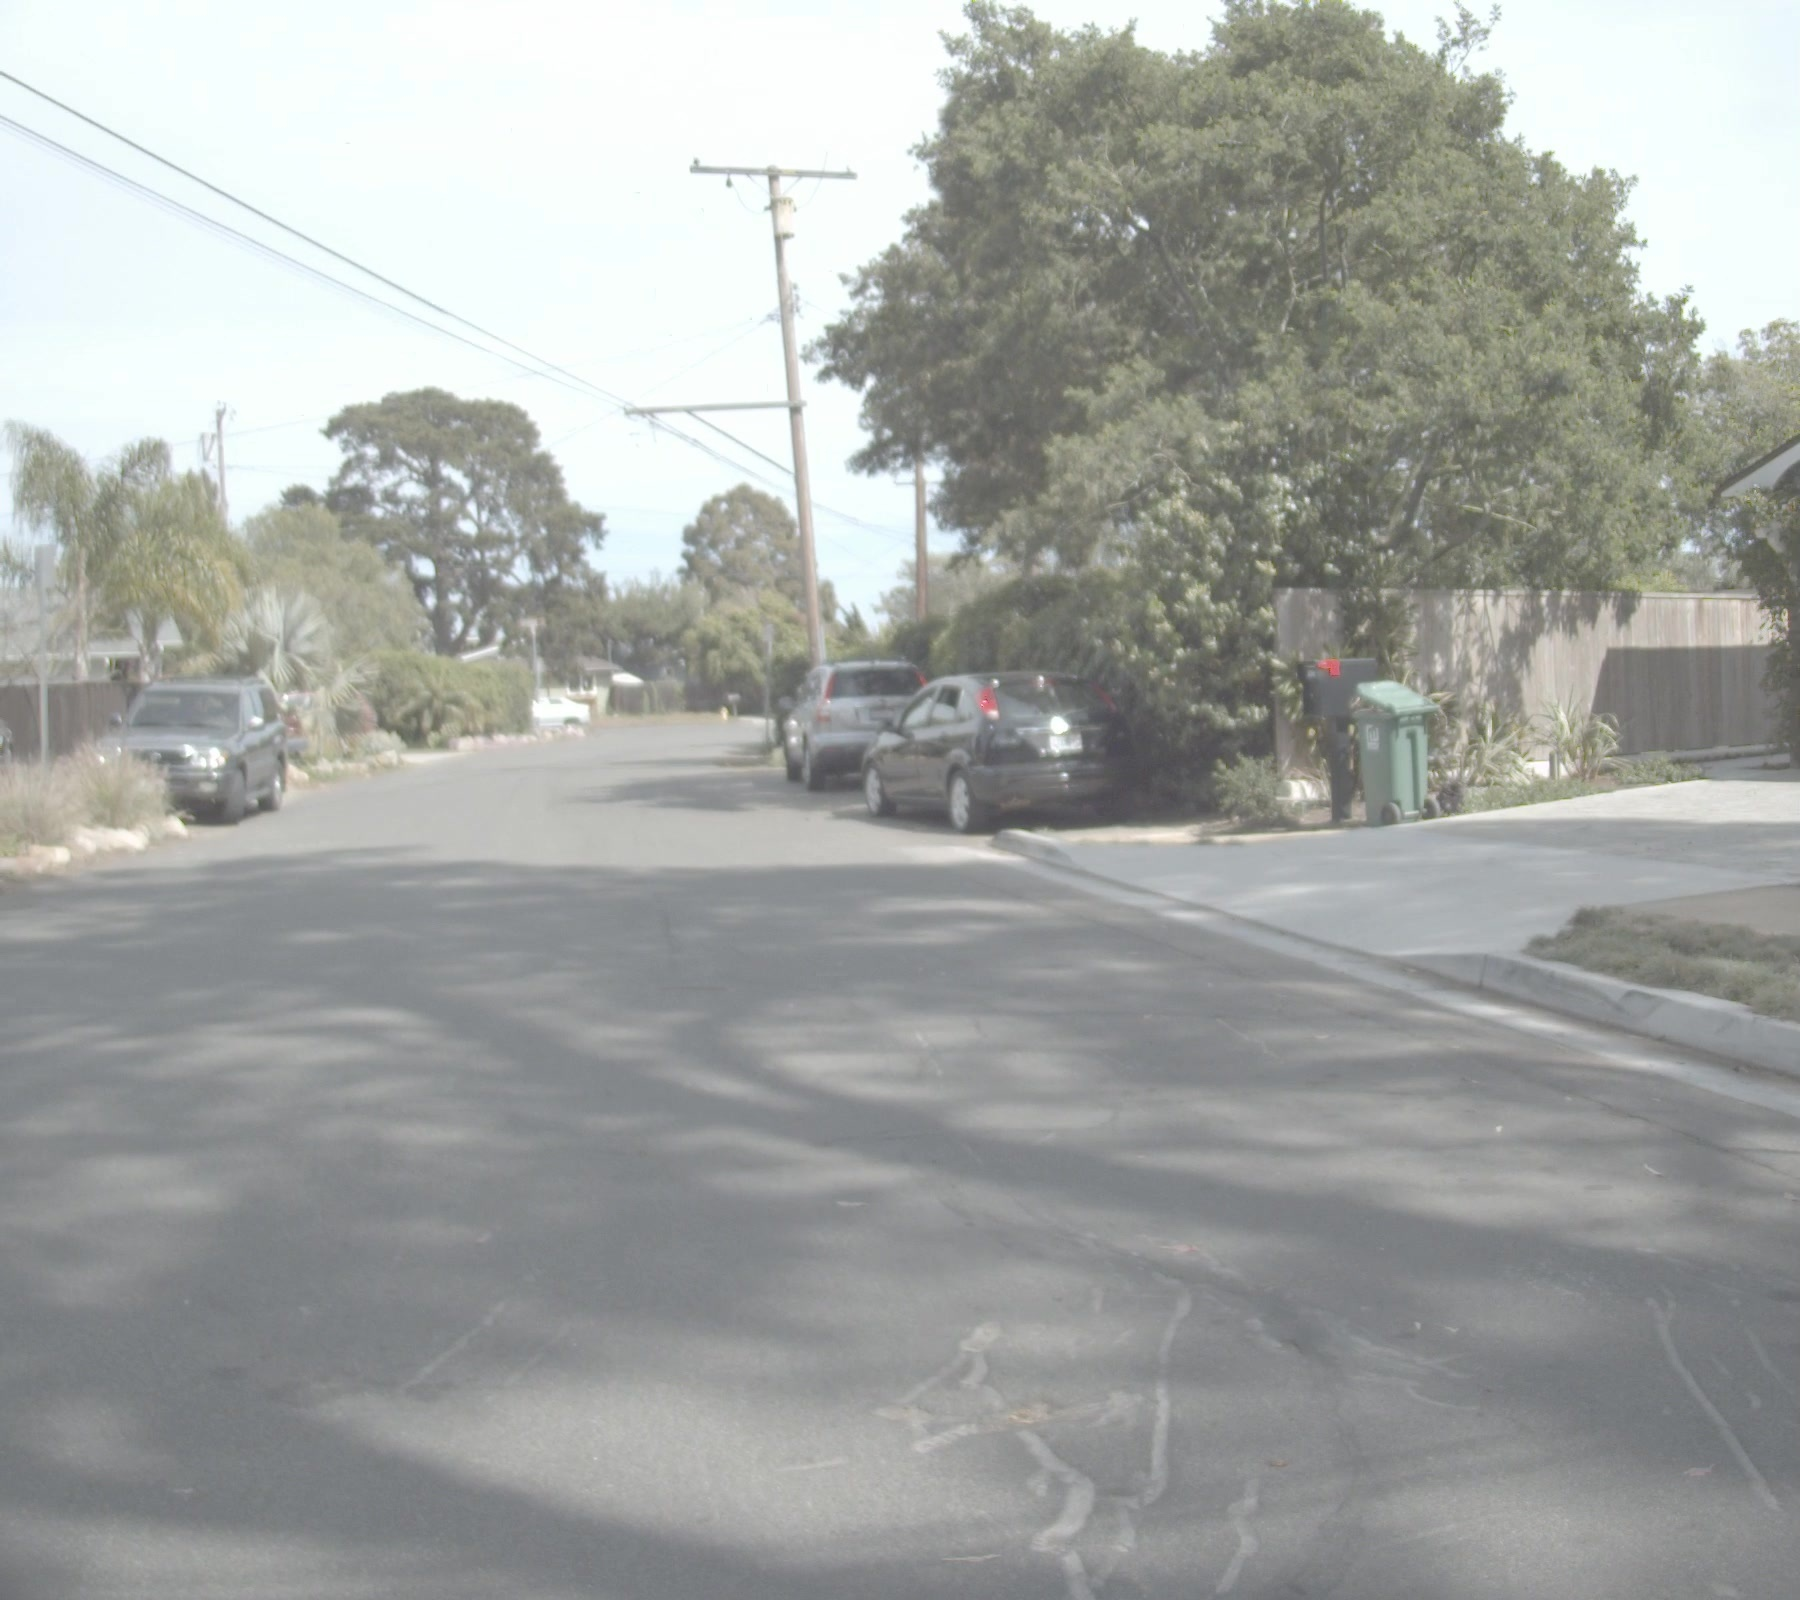

In [ ]:
Image.open(files[2])

In [1]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, device_map="auto")

/home/govind/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-01 19:06:58.106930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 19:06:58.628349: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-01 19:06:58.628390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [5]:
dataset = load_dataset("imagefolder", data_dir=DATA_DIR)

Generating train split: 10742 examples [00:00, 27951.38 examples/s]


In [6]:
for x in dataset['train'].iter(batch_size=1):
    print(x)

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B35F55F60>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B2C2B3BB0>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B35F553F0>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B2C2B3BB0>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B35F55F30>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B2C2B3BB0>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B35F56C20>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B2C2B3BB0>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B35F54FA0>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x512 at 0x7F1B2C2B3BB0>]}
{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=640x51

KeyboardInterrupt: 

In [7]:
for i, batch in enumerate(dataset['train'].iter(batch_size=1)):
    prompt = "USER: <image>\nGive a very concise caption for the image.\nASSISTANT:"
    inputs = processor(prompt, images=batch['image'], padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=200)
    completed_prompts = processor.batch_decode(output, skip_special_tokens=True)

    captions = ['sks a photo of ' + completed_prompt.split('ASSISTANT: ')[1].lower() for completed_prompt in completed_prompts]
    
    for f, c in zip(filelist, captions):
        print(f)
        print(c)
        d[f] = c

NameError: name 'filelist' is not defined

In [10]:
d = {}

files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
loader = torch.utils.data.DataLoader(files, batch_size=8)
for i, batch in enumerate(loader):
    prompt = "USER: <image>\nGive a very concise caption for the image.\nASSISTANT:"
    inputs = processor([prompt for _  in batch], images=[Image.open(file) for file in batch], padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=200)
    completed_prompts = processor.batch_decode(output, skip_special_tokens=True)

    captions = [completed_prompt.split('ASSISTANT: ')[1].lower() for completed_prompt in completed_prompts]
    
    for f, c in zip(batch, captions):
        print(f)
        print(c)
        d[f] = c

/scratch/govind/modality_translation/images_thermal_train/data/video-AEZAaF8epmvQv5Nfj-frame-009629-g3ckpghgD5CRJqHrM.jpg
a group of people walking down a street at night.
/scratch/govind/modality_translation/images_thermal_train/data/video-ELruYFQjkqpZnir29-frame-003174-eecyBKvvyQ75MxFrX.jpg
a black and white photo of a street with cars and traffic lights.
/scratch/govind/modality_translation/images_thermal_train/data/video-TTDq3x6HSvFx3YRDH-frame-001049-NwrB4sbE2APoLjS8Z.jpg
a black and white photo of a street with a bike lane.
/scratch/govind/modality_translation/images_thermal_train/data/video-TTDq3x6HSvFx3YRDH-frame-001169-f4GPmW6AE3rbnHhCF.jpg
a black and white photo of a street with a man walking down the sidewalk.
/scratch/govind/modality_translation/images_thermal_train/data/video-ZicHYAPRYGdu82nAa-frame-003471-g2gvndmv8n7EoycbH.jpg
a man riding a bike on a street at night.
/scratch/govind/modality_translation/images_thermal_train/data/video-ZicHYAPRYGdu82nAa-frame-001912-x9Yv

KeyboardInterrupt: 

: 